In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)

import time
import os
import cv2
print(tf.__version__)

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]

1.12.0


In [2]:
POS_TARGET_DIR = './data/pruned/good'
NEG_TARGET_DIR = './data/pruned/bad'
T_WIDTH = 175
T_HEIGHT = 300

In [3]:
def strong_aug(p=.5):
    return Compose([
        Flip(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.3),
            MedianBlur(blur_limit=3, p=0.2),
            Blur(blur_limit=3, p=0.2),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.2),
            IAAPiecewiseAffine(p=0.2),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.5),
        HueSaturationValue(p=0.3),
    ], p=p)

def augment_flips_color(p=.5):
    return Compose([
        CLAHE(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=15, p=.75),
        Blur(blur_limit=3),
        OpticalDistortion(),
        GridDistortion(),
        HueSaturationValue()
    ], p=p)

In [4]:
def load_images_from_path(path):
    ds = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.resize(img, (T_WIDTH, T_HEIGHT))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ds.append(img)
    return ds

In [5]:
pos_images = load_images_from_path(POS_TARGET_DIR)
neg_images = load_images_from_path(NEG_TARGET_DIR)

In [38]:
X_pos = np.array(pos_images)
X_neg = np.array(neg_images)
y_pos = np.ones(X_pos.shape[0])
y_neg = np.zeros(X_neg.shape[0])
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos, y_pos, test_size=0.2, shuffle=True)
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg, y_neg, test_size=0.2, shuffle=True)
X_train = np.concatenate([X_pos_train, X_neg_train])
y_train = np.concatenate([y_pos_train, y_neg_train])
X_test = np.concatenate([X_pos_test, X_neg_test])
y_test = np.concatenate([y_pos_test, y_neg_test])

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3933, 300, 175, 3), (984, 300, 175, 3), (3933,), (984,))

In [39]:
aug = augment_flips_color(p=1)
def aug_wrapper(img):
    return aug(image=img)

In [40]:
X_train.shape[0]

3933

In [41]:
pool = Pool(processes=30)
pos_images_aug = [el['image'] for el in pool.map(aug_wrapper, [X_pos_train[i] for i in range(X_pos_train.shape[0])])]
neg_images_aug = [el['image'] for el in pool.map(aug_wrapper, [X_neg_train[i] for i in range(X_neg_train.shape[0])])]
pool.close()

In [42]:
X_pos_aug = np.array(pos_images_aug)
X_neg_aug = np.array(neg_images_aug)
y_pos_aug = np.ones(X_pos_aug.shape[0])
y_neg_aug = np.zeros(X_neg_aug.shape[0])
X_train_aug = np.concatenate([X_train, X_pos_aug, X_neg_aug])
y_train_aug = np.concatenate([y_train, y_pos_aug, y_neg_aug])
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)

In [43]:
X_train_aug = X_train_aug / 255.
X_test = X_test / 255.

In [19]:
X_train_aug.shape, y_train_aug.shape

((8850, 300, 175, 3), (8850,))

1.0


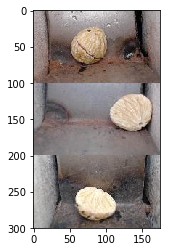

1.0


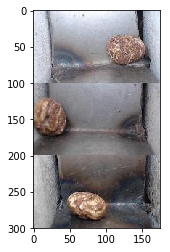

1.0


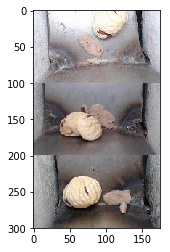

1.0


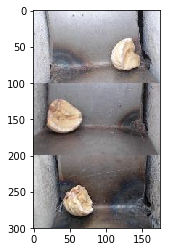

1.0


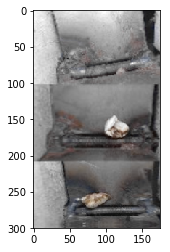

1.0


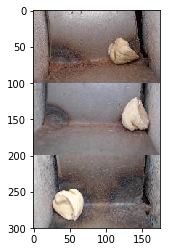

1.0


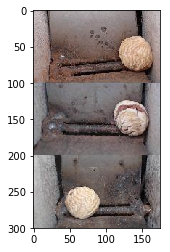

1.0


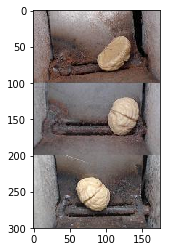

1.0


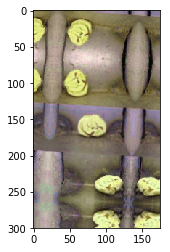

1.0


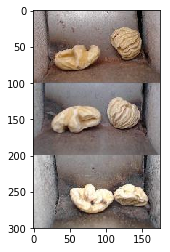

1.0


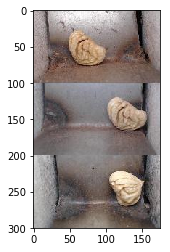

1.0


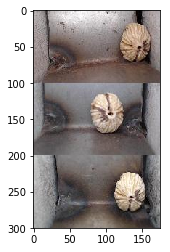

1.0


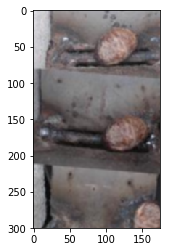

1.0


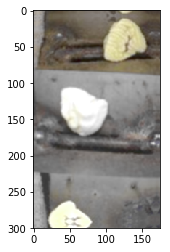

1.0


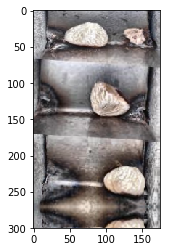

1.0


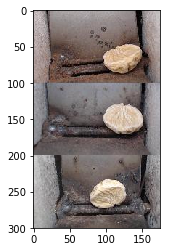

1.0


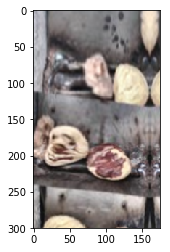

1.0


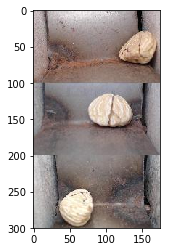

1.0


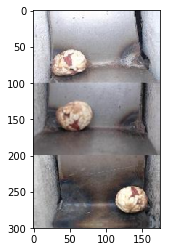

1.0


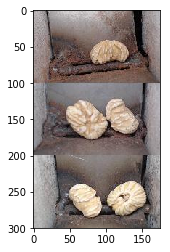

In [44]:
# img = cv2.cvtColor(neg_images[1844],cv2.COLOR_BGR2RGB)
for i in range(20):
    img = X_train_aug[i]
    print(y_train[i])
    # img = cv2.resize(img, (175, 300))
    plt.imshow(img)
    plt.show()

In [45]:
image_input = tf.keras.Input(shape=(T_HEIGHT, T_WIDTH, 3), name='input_layer')

# Some convolutional layers
conv_1 = keras.layers.Conv2D(32,
                                kernel_size=(5, 5),
                                padding='same',
                                activation='relu')(image_input)
conv_1 = keras.layers.MaxPooling2D(padding='same')(conv_1)
conv_2 = keras.layers.Conv2D(32,
                                kernel_size=(4, 4),
                                padding='same',
                                activation='relu')(conv_1)
conv_2 = keras.layers.MaxPooling2D(padding='same')(conv_2)
conv_3 = keras.layers.Conv2D(32,
                                kernel_size=(3, 3),
                                padding='same',
                                activation='relu')(conv_1)
conv_3 = keras.layers.MaxPooling2D(padding='same')(conv_2)

# Flatten the output of the convolutional layers
conv_flat = keras.layers.Flatten()(conv_3)

# Some dense layers with two separate outputs
fc_1 = keras.layers.Dense(64,
                             activation='relu')(conv_flat)
fc_1 = keras.layers.Dropout(0.3)(fc_1)
fc_2 = keras.layers.Dense(64,
                             activation='relu')(fc_1)
fc_2 = keras.layers.Dropout(0.3)(fc_2)

# Output layers: separate outputs for the weather and the ground labels
output = keras.layers.Dense(2,
                            activation='softmax',
                            name='output')(fc_2)
model = tf.keras.Model(inputs=image_input, outputs=[output])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 300, 175, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 300, 175, 32)      2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 150, 88, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 88, 32)       16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 44, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 38, 22, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26752)             0         
__________

In [47]:
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer='adam',
              loss={'output': 'binary_crossentropy'},
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()))


In [48]:
X_train.shape, y_train.shape
print(y_train)

y_train_cat = keras.utils.to_categorical(y_train_aug, num_classes=2)
y_test_cat =  keras.utils.to_categorical(y_test, num_classes=2)

[1. 1. 1. ... 0. 0. 0.]


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc')

In [49]:
with tf.device('/gpu:0'):
    model.fit(X_train_aug, y_train_cat, 
              validation_split=0.1, 
              batch_size=32, 
              epochs=8, 
              verbose=1, 
              shuffle=True,
              callbacks=[tensorboard])

Train on 7079 samples, validate on 787 samples
Epoch 1/8
7079/7079 [==============================] - 25s 4ms/step - loss: 0.3588 - acc: 0.8100 - val_loss: 0.1389 - val_acc: 0.9466
Epoch 2/8
7079/7079 [==============================] - 24s 3ms/step - loss: 0.1161 - acc: 0.9544 - val_loss: 0.1047 - val_acc: 0.9568
Epoch 3/8
7079/7079 [==============================] - 23s 3ms/step - loss: 0.0989 - acc: 0.9617 - val_loss: 0.1546 - val_acc: 0.9339
Epoch 4/8
7079/7079 [==============================] - 23s 3ms/step - loss: 0.0862 - acc: 0.9671 - val_loss: 0.1493 - val_acc: 0.9327
Epoch 5/8
7079/7079 [==============================] - 22s 3ms/step - loss: 0.0823 - acc: 0.9672 - val_loss: 0.1077 - val_acc: 0.9581
Epoch 6/8
7079/7079 [==============================] - 23s 3ms/step - loss: 0.0764 - acc: 0.9716 - val_loss: 0.1049 - val_acc: 0.9568
Epoch 7/8
7079/7079 [==============================] - 23s 3ms/step - loss: 0.0686 - acc: 0.9729 - val_loss: 0.1026 - val_acc: 0.9619
Epoch 8/8
7079/

In [50]:
model.evaluate(X_test, y_test_cat, batch_size=512)

984/984 [==============================] - 3s 3ms/step


[0.008259932297757061, 0.9989837398373984]

In [51]:
model.save('sort.h5')

In [23]:
del model

In [ ]:
model = keras.models.load_model('detect_empty.h5')

In [28]:
y_pred_cat = model.predict(X_test, batch_size=256)
y_pred_cat

array([[5.3648647e-10, 1.0000000e+00],
       [1.0734785e-06, 9.9999893e-01],
       [6.9885729e-08, 9.9999988e-01],
       ...,
       [3.3914429e-09, 1.0000000e+00],
       [4.1659075e-07, 9.9999964e-01],
       [1.0000000e+00, 6.6664744e-22]], dtype=float32)

In [29]:
y_pred = np.argmax(y_pred_cat, axis=1)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       547
         1.0       1.00      1.00      1.00       437

   micro avg       1.00      1.00      1.00       984
   macro avg       1.00      1.00      1.00       984
weighted avg       1.00      1.00      1.00       984



In [ ]:
labels = im[1]
images = im[0]

In [ ]:
labels.shape

In [ ]:
labels[1] == float(0)

In [ ]:
labels = labels.astype(int)

In [ ]:
l0 = model.layers[0]
l0.get_config()

In [ ]:
np.where(labels == 0)

In [ ]:
# Look at samples from each class
MAX = 100
label = 0
elements = np.where(labels == label)[0]
np.random.shuffle(elements)
for c, id in enumerate(elements):
    print("Id: {}, Label: {}".format(id, labels[id]))
    plt.imshow(images[id])
    plt.show()
    if c > MAX:
        break
    

In [ ]:
nb_epochs = 60

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[tensorboard])

In [ ]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

In [ ]:
with tf.Session() as sess:
  devices = sess.list_devices()

In [ ]:
devices

In [ ]:
K.clear_session()

In [ ]:
import tqdm
import time
for i in tqdm.tqdm(range(100)):
    time.sleep(1)